#Парсинг сообщений с сайта woman.ru

In [ ]:
!pip install fake_useragent

In [ ]:
import requests
from pprint import pprint
from fake_useragent import UserAgent
import random
from bs4 import BeautifulSoup
import re
from tqdm.auto import tqdm
import pandas as pd
import time
from datetime import datetime
import json

In [ ]:
session = requests.session()
ua = UserAgent()
headers = {'User-Agent': ua.random}

In [ ]:
import json

def parse_each_topic(topic):
  # выбрала топовые треды в теме
  url_one = f'https://www.woman.ru/{topic}/forum/?sort=all'
  req = session.get(url_one, headers={'User-Agent': ua.random})
  page = req.text
  soup = BeautifulSoup(page, 'html.parser')
  news = soup.find_all('a', {'class': 'list-item__link'})
  threads = []
  # взяла десять тредов с 1 по 20 с шагом 2, чтобы были разные даты создания
  for i in tqdm(news[0:20:2]):
    thread = {}
    link = i.attrs['href']
    try:
      year = int(i.find('time', {'class': 'list-item__date'}).text.split(', ')[0].split()[-1])
      year_for_div = 2024 - year
    except Exception as e:
      print(e)
    name = i.find('h3', {'class': 'list-item__title list-item__title_visited text_weight_medium'}).text
    thread['name'] = name
    url_for_first = f'https://www.woman.ru' + link
    req = session.get(url_for_first, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    num_of = soup.find_all('a', {'class': 'pager__link'})
    num_of_last_page = int(num_of[-2].text)
    # шаг – количество страниц, которое пропускаю, чтобы перейти на следующее
    # нужно, чтобы равномерно выбрать сообщения по дате их отправки
    # беру номер последней страницы и делю на 6, либо на количество лет с дня открытия треда
    # конечно, это не очень хорошо, так как я рассчитываю при такой формуле на то, что данные распределены по страница
    # равномерно в зависимости от года, но это естественно не так
    shag = int(num_of_last_page / max(6, year_for_div))
    comments = []
    for n in range(1, num_of_last_page, shag):
      urlik = ' https://www.woman.ru' + link + f'{n}/'
      time.sleep(random.uniform(1.1, 3.3))
      req = session.get(urlik, headers={'User-Agent': ua.random})
      page = req.text
      soup = BeautifulSoup(page, 'html.parser')
      full_l = soup.find_all('div', {'class': 'card__text'})
      for element in full_l[1:]:
        one_comment = {}
        try:
          list_of_years = element.find('time').text.split(', ')[0].split()
          if len(list_of_years) == 3:
            one_comment['year'] = int(list_of_years[-1])
          else:
            one_comment['year'] = 2023
          one_comment['text'] = element.find('p', {'class': 'card__comment'}).text
          comments.append(one_comment)
        except Exception:
          pass
    thread['comments'] = comments
    threads.append(thread)
  # создаю json-файл для каждого топика
  with open(f"{topic}.json", "w", encoding='utf-8') as final:
    json.dump(threads, final, ensure_ascii=False)
  return final

In [ ]:
topics = ['relations', 'psycho', 'health', 'kids', 'home', 'beauty', 'fashion', 'rest', 'stars']
for top in tqdm(topics):
  parse_each_topic(top)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

# делаю из каждого файлы один датасет
topics = ['relations', 'psycho', 'health', 'kids', 'home', 'beauty', 'fashion', 'rest', 'stars']
ls = []
df_list = []
for name in topics:
  with open(f'{name}.json') as f:
    data = json.load(f)
  df = pd.json_normalize(data,'comments', ['name'])
  df.insert(0, "topic", [name] * len(df), allow_duplicates=True)
  ls.append(len(df))
  df_list.append(df)
df_final = pd.concat(df_list, axis=0)
df_final.to_csv('woman.ru – 9 topic.csv', index=False)

#Обучение модели

#Описание


1.   Для обучения был взят датасет по ссылке https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments
2.   Посмотрела на два метода: логистическая регрессия и метод опорных векторов
3.   Остановилась на логистической регрессии



In [ ]:
!pip install pymystem3

нижний регистр, токены, леммы, убрать стоп-слова

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import spacy
from pymystem3 import Mystem


nltk.download('stopwords')
nltk.download('punkt')


stop_words = stopwords.words('russian')
punctuation = string.punctuation
m = Mystem()

kag_df = pd.read_csv('labeled.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# функция, которая возвращает текст, состоящий из лемм
def preprocessing(text):
  review_l = []
  for lemma in m.lemmatize(text):
    if lemma not in stop_words and lemma.isalpha():
      review_l.append(lemma)
  return ' '.join(review_l)


In [3]:
# проверка, что в колонке с текстом нет пропусков
kag_df['comment'].isnull().any().sum()

0

In [4]:
kag_df['comment'] = kag_df['comment'].apply(preprocessing)

In [5]:
X = kag_df['comment']
y = kag_df['toxic']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
vctrz = TfidfVectorizer(analyzer='word', norm='l2')
lr = LogisticRegression()

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

pipe = Pipeline(steps=[('vectorizer', vctrz), ('model', lr)])

params = [i for i in range(1, 50, 2)]
parameters = [{'model__C': params}]
grid_search = GridSearchCV(pipe, parameters, cv=5)
grid_search.fit(X_train, y_train)
pipe_best = grid_search.best_estimator_
pipe_best.named_steps
pipe_best.fit(X_train, y_train)
print(classification_report(y_test, pipe_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      1918
         1.0       0.86      0.73      0.79       965

    accuracy                           0.87      2883
   macro avg       0.86      0.83      0.84      2883
weighted avg       0.87      0.87      0.86      2883



In [42]:
# моедль выбрала коэффициент регуляризации равным 17
print(pipe_best)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', LogisticRegression(C=17))])


In [ ]:
int(pipe_best.predict(['Ты добрый человек']))
int(pipe_best.predict(['Ты добрый говнюк']))

In [ ]:
# здесь результаты получились похожими, поэтому я выбираю логистическую регрессию
# так как она обучается быстрее
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

svm = SVC(kernel="linear")

pipe2 = Pipeline(steps=[('vectorizer', vctrz), ('model', svm)])

params = [i for i in range(1, 25, 2)]
parameters = [{'model__C': params}]
grid_search = GridSearchCV(pipe2, parameters, cv=5)
grid_search.fit(X_train, y_train)
pipe_best2 = grid_search.best_estimator_
pipe_best2.named_steps
pipe_best2.fit(X_train, y_train)
print(classification_report(y_test, pipe_best2.predict(X_test)))

In [ ]:
print(pipe_best2)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', SVC(C=1, kernel='linear'))])


In [34]:
# с деревом как-то плохо, но мб параметры нужно было подбирать
from sklearn.tree import DecisionTreeClassifier

X_train = vctrz.fit_transform(X_train)
X_test = vctrz.transform(X_test)
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83      1918
         1.0       0.67      0.69      0.68       965

    accuracy                           0.78      2883
   macro avg       0.75      0.76      0.76      2883
weighted avg       0.78      0.78      0.78      2883



In [8]:
import joblib

# сохраняю модель
joblib.dump(pipe_best, "model.pkl")

['model.pkl']

#Применение модели к собранному с форума датасету

In [9]:
woman = pd.read_csv('woman.ru – 9 topic.csv')
woman = woman.dropna()
predictions = pipe_best.predict(woman['text'])
woman['prediction'] = predictions.tolist()

In [10]:
woman.to_csv('woman_predicted.csv')

In [11]:
import pandas as pd

res = pd.read_csv('woman_predicted.csv')
re1 = res.groupby('year', as_index=False)['prediction'].mean()
re1['year'].tolist()
re2 = res.groupby('topic', as_index=False)['prediction'].mean()

#Построение графиков

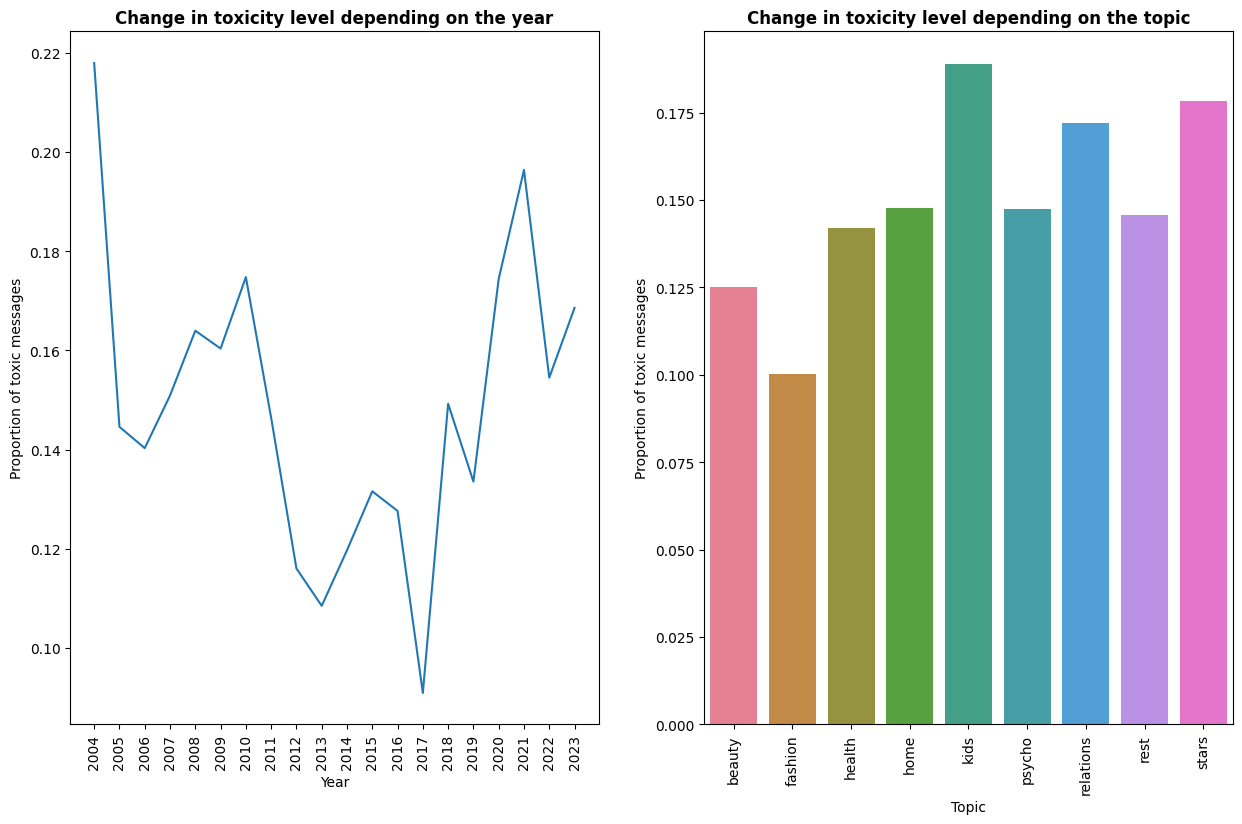

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(1, 2, figsize=(15, 9))

plt.subplot(1, 2, 2)
sns.barplot(x=re2['topic'].tolist(), y=re2['prediction'].tolist(), legend=False, palette='husl')
plt.xlabel('Topic')
plt.ylabel('Proportion of toxic messages')
plt.title('Сhange in toxicity level depending on the topic', weight='bold')
plt.xticks(rotation=90)

plt.subplot(1, 2, 1)
plt.plot(re1['year'].tolist(), re1['prediction'])
plt.xlabel('Year')
plt.ylabel('Proportion of toxic messages')
plt.title('Сhange in toxicity level depending on the year', weight='bold')
plt.xticks(re1['year'].tolist(), re1['year'].tolist(), rotation=90)


plt.savefig('diagram.jpg')
plt.show();

In [10]:
def preprocessing_cloud(text):
  review_l = []
  for lemma in m.lemmatize(text):
    if lemma not in stop_words and lemma.isalpha():
      review_l.append(lemma)
  return review_l


In [11]:
data = res.groupby('prediction')['text'].apply(lambda x: ' '.join(x))
toxic = data.loc[1.0]
non_toxic = data.loc[0.0]
toxic_l = preprocessing_cloud(toxic)

In [12]:
non_toxic_l = preprocessing_cloud(non_toxic)

In [13]:
toxic_l = ' '.join(toxic_l)

In [14]:
non_toxic_l = ' '.join(non_toxic_l)

##Это облака слов для токсичных сообщений и нетоксичных. Как видно из диаграммы, сильной разницы нет

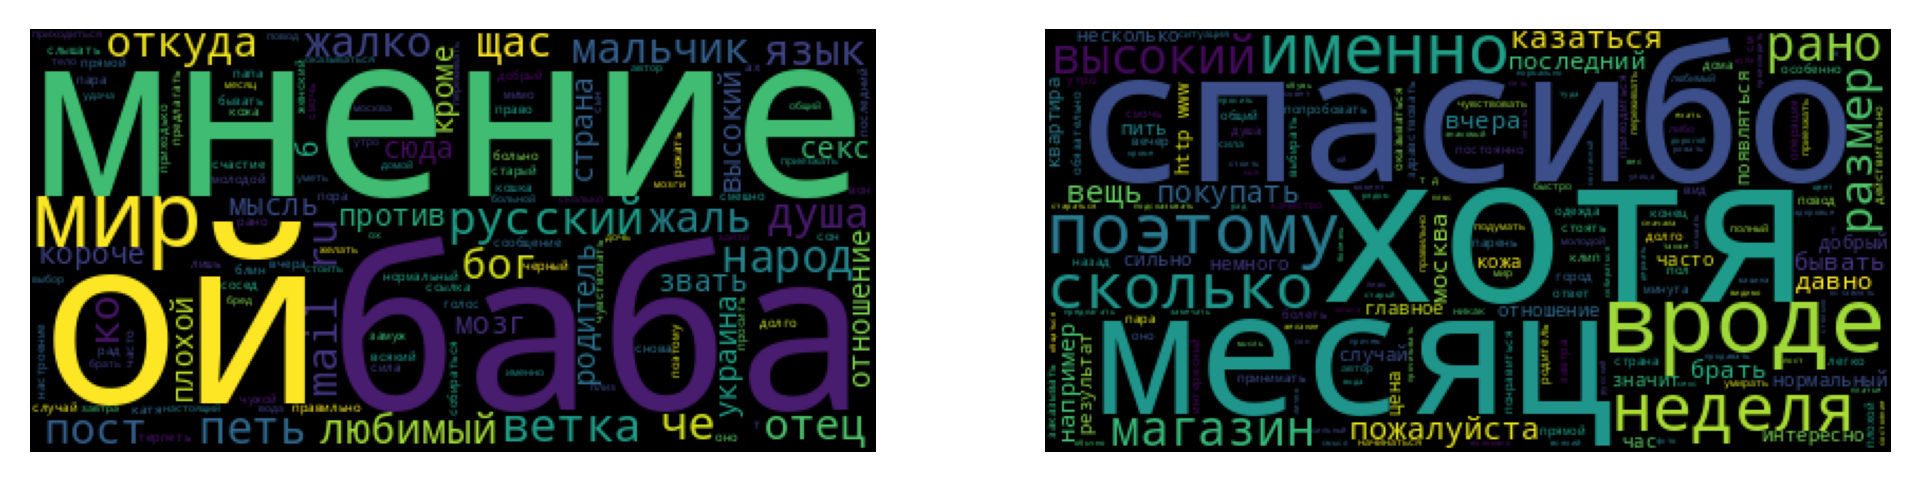

In [16]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stopwords_p = stopwords.words('russian')
toxic_cloud = WordCloud(stopwords=stopwords_p).generate(toxic_l)
non_toxic_cloud = WordCloud(stopwords=stopwords_p).generate(non_toxic_l)
toxic_freq = Counter(toxic_cloud.words_).most_common(500)
non_toxic_freq = Counter(non_toxic_cloud.words_).most_common(500)
# words which are among popular in both lists
common_words_p = [word for word, freq in toxic_freq if word in [word for word, freq in non_toxic_freq]]
for word in common_words_p:
  stopwords_p.append(word)
stopwords_p.extend(['быть', "нравиться", "ничто", "никто", "наш", "сегодня", "ждать", "написать", "дело", "ходить", "казаться", "давать",
                      "мочь", "сказать", "говорить", "хотеть", "иметь", "видеть", "думать", "сделать", "понимать", "жить", "делать", "работать", "стоять", "считать", "смотреть", "взять", "получать",
 "сидеть", "становиться", "спросить", "время", "ваш", "хороший", "жизнь", "день", "твой", "писать", "получаться", "находить", "хотя", "вообще", "неделя", "нужно", "являться", "привет", "принимать", "пока", "становиться", "начинать", "каждый", "называть", "идти", "пойти", "оставаться"])
toxic_cloud = WordCloud(stopwords=stopwords_p).generate(toxic_l)


stopwords_n = stopwords.words('russian')
# words which are among popular in both lists
common_words_n = [word for word, freq in non_toxic_freq if word in [word for word, freq in toxic_freq]]
for word in common_words_n:
  stopwords_n.append(word)
# added this etension based on previous tries
non_toxic_cloud = WordCloud(stopwords=stopwords_n).generate(non_toxic_l)

# cocatenate two plots in one
plt.figure(figsize=(8, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(toxic_cloud)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(non_toxic_cloud)
plt.axis("off")

plt.show()

##Здесь я сделала облака слов для каждой темы. В целом, они отражают каждый топик

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import spacy
from pymystem3 import Mystem


nltk.download('stopwords')
nltk.download('punkt')


stop_words = stopwords.words('russian')
punctuation = string.punctuation
m = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import pandas as pd

res = pd.read_csv('woman_predicted.csv')

In [4]:
def preprocessing_cloud_topic(text):
  review_l = []
  for lemma in m.lemmatize(text):
    if lemma not in stop_words and lemma.isalpha():
      review_l.append(lemma)
  return ' '.join(review_l)


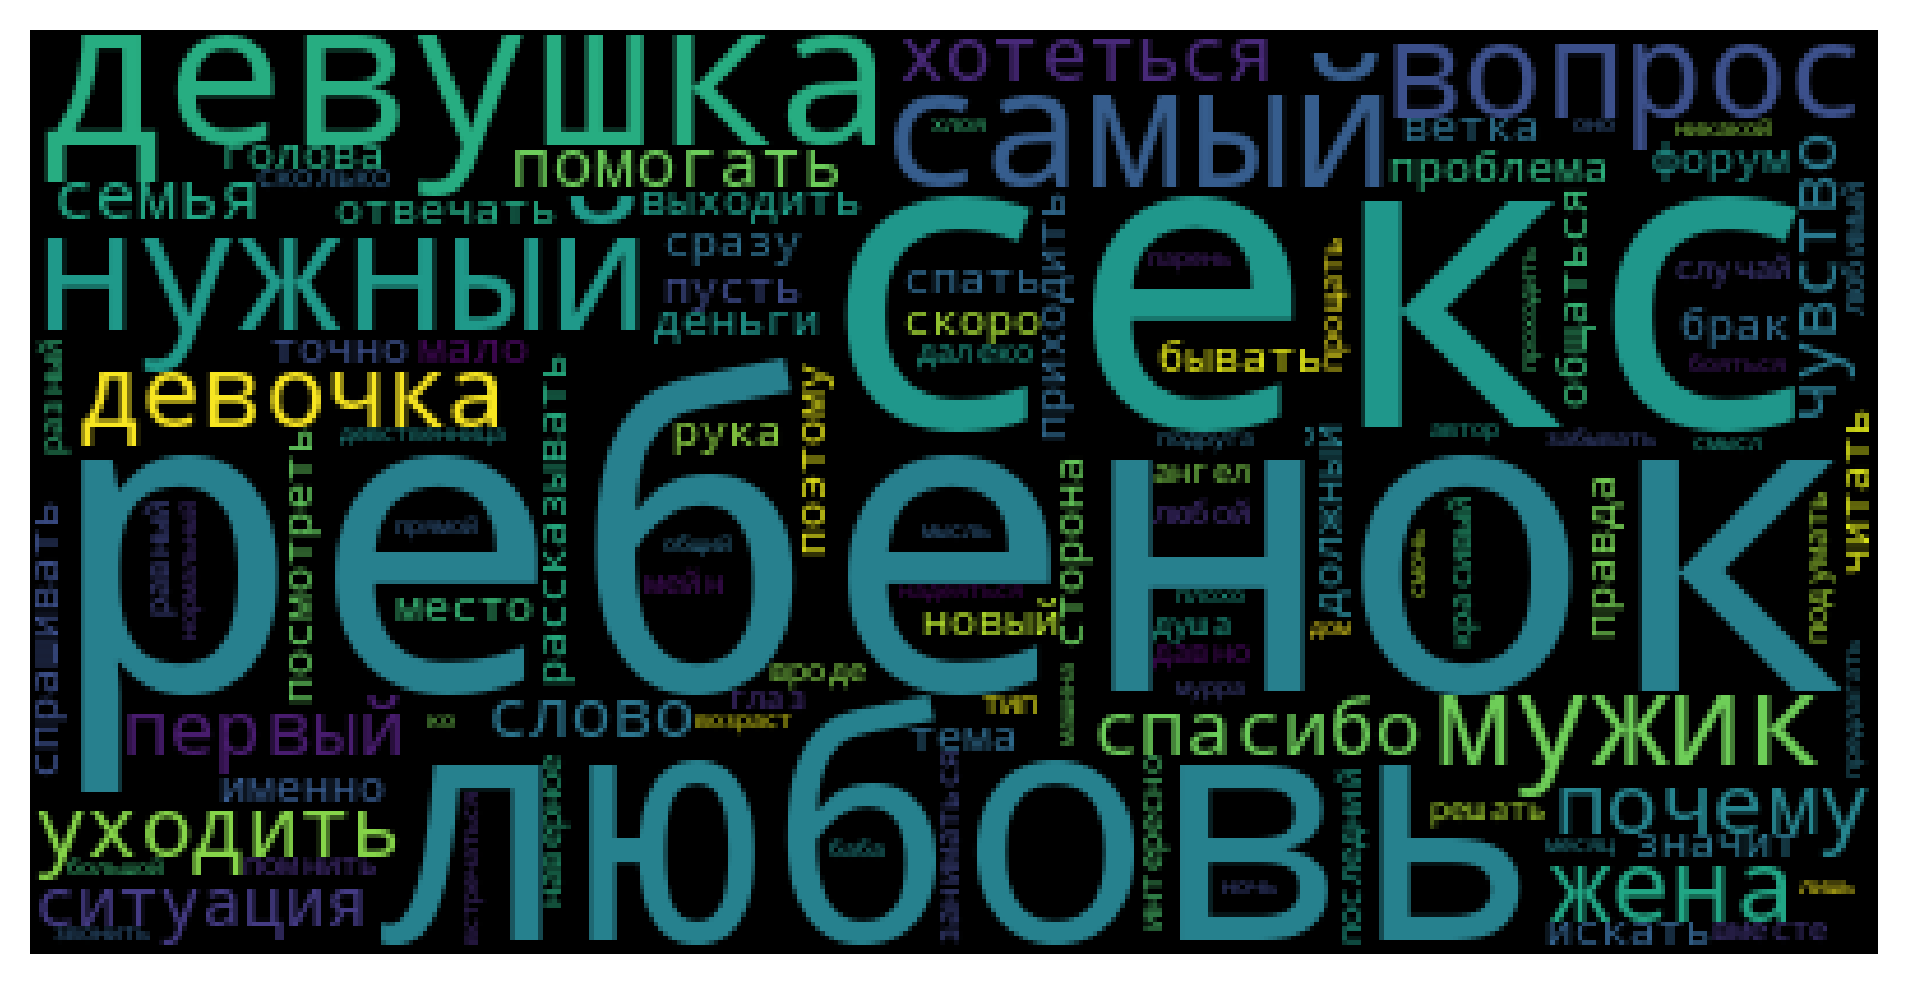

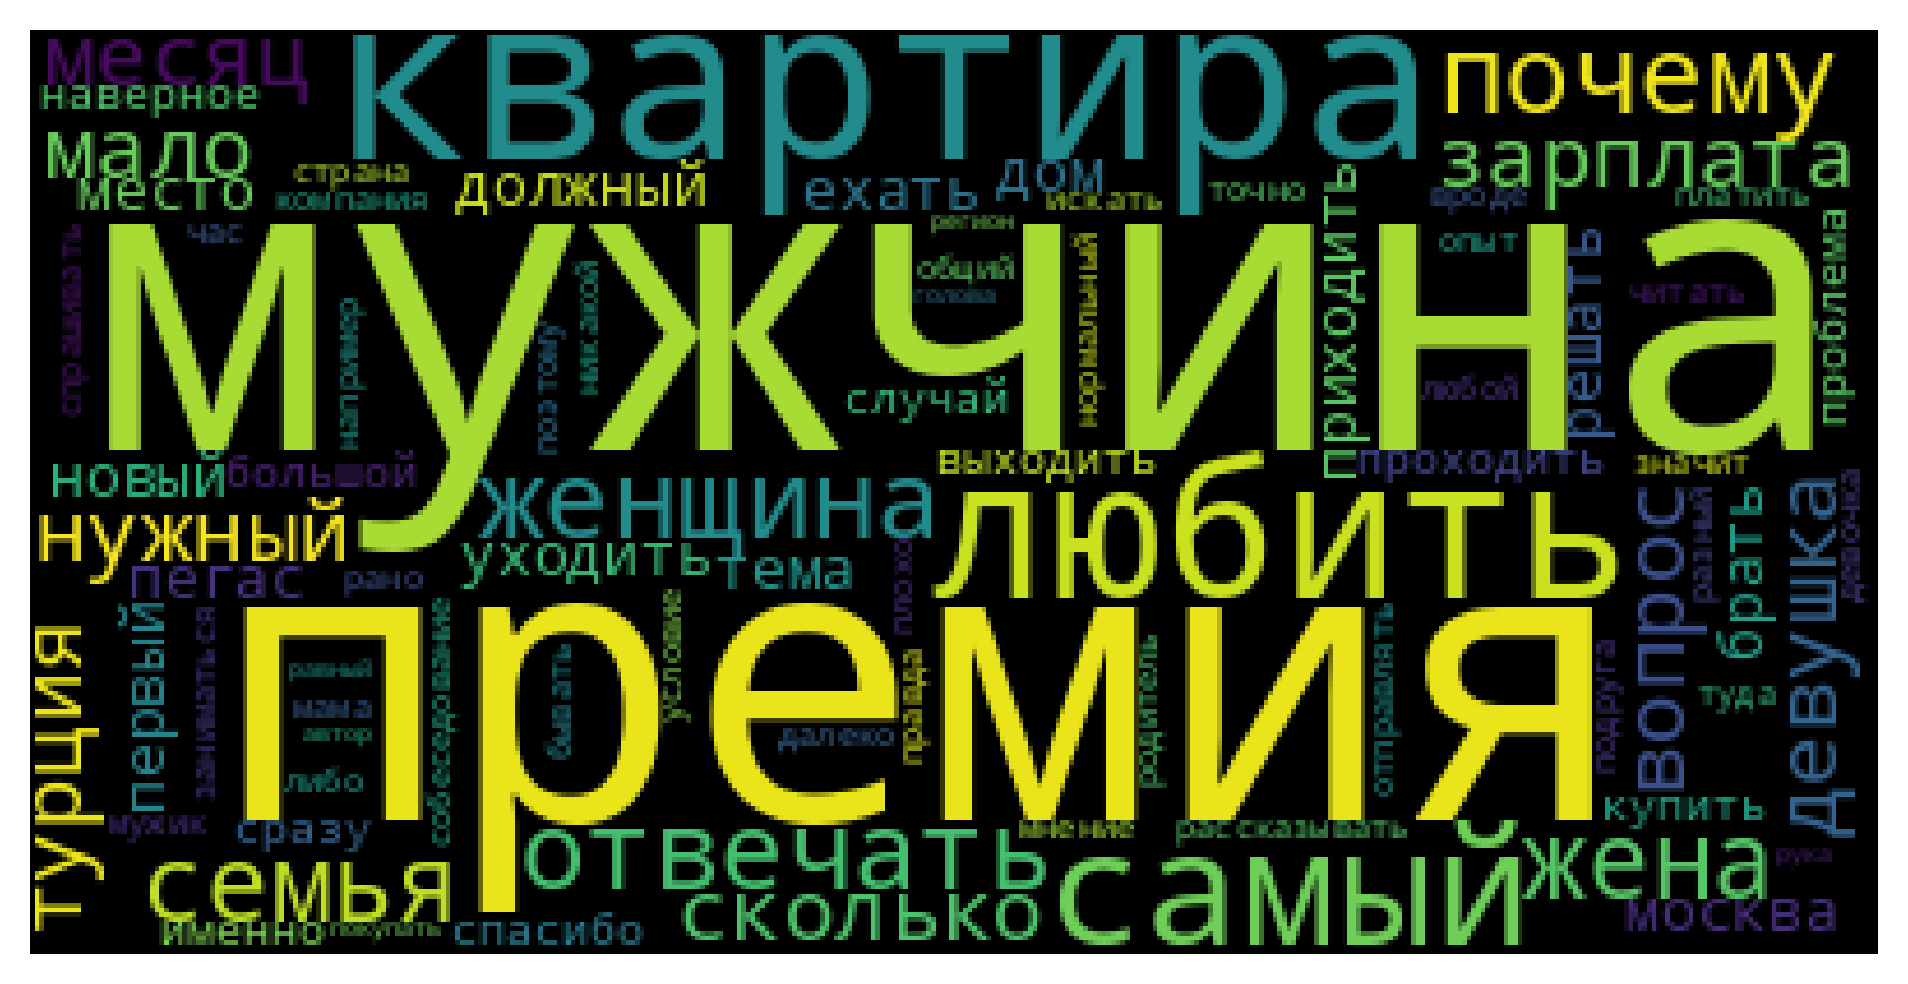

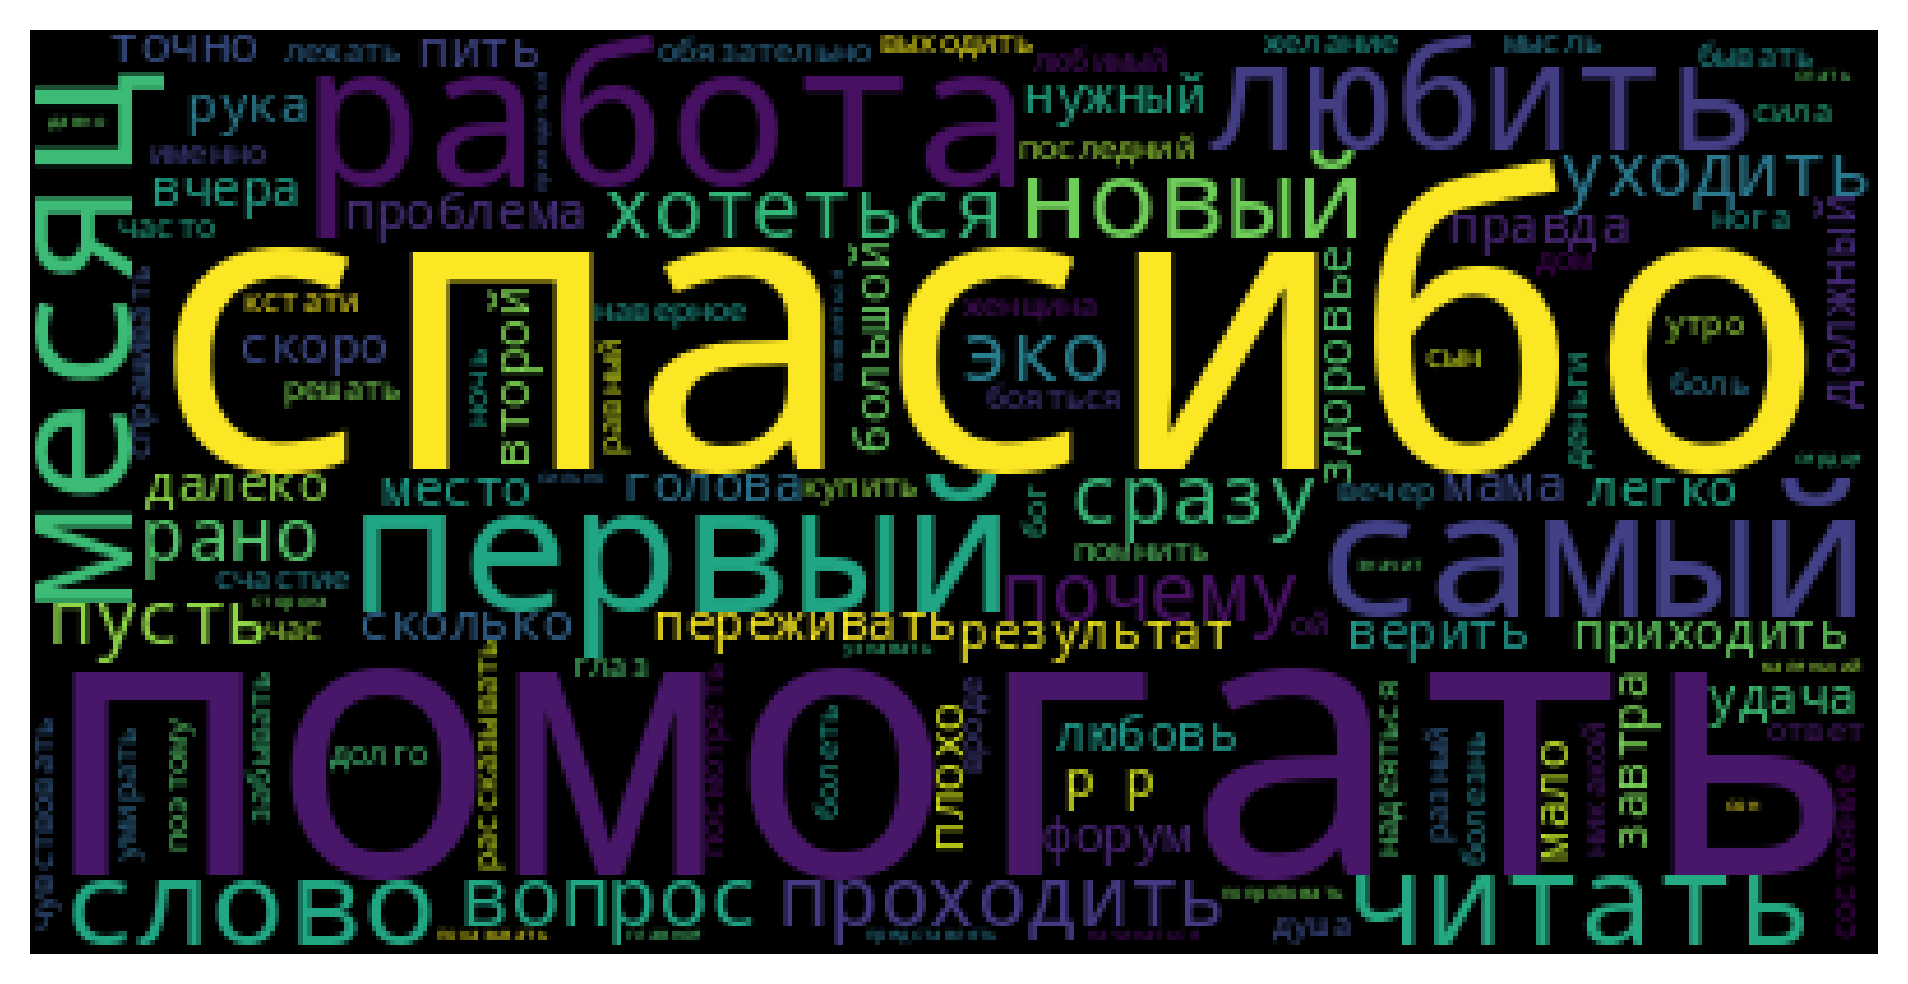

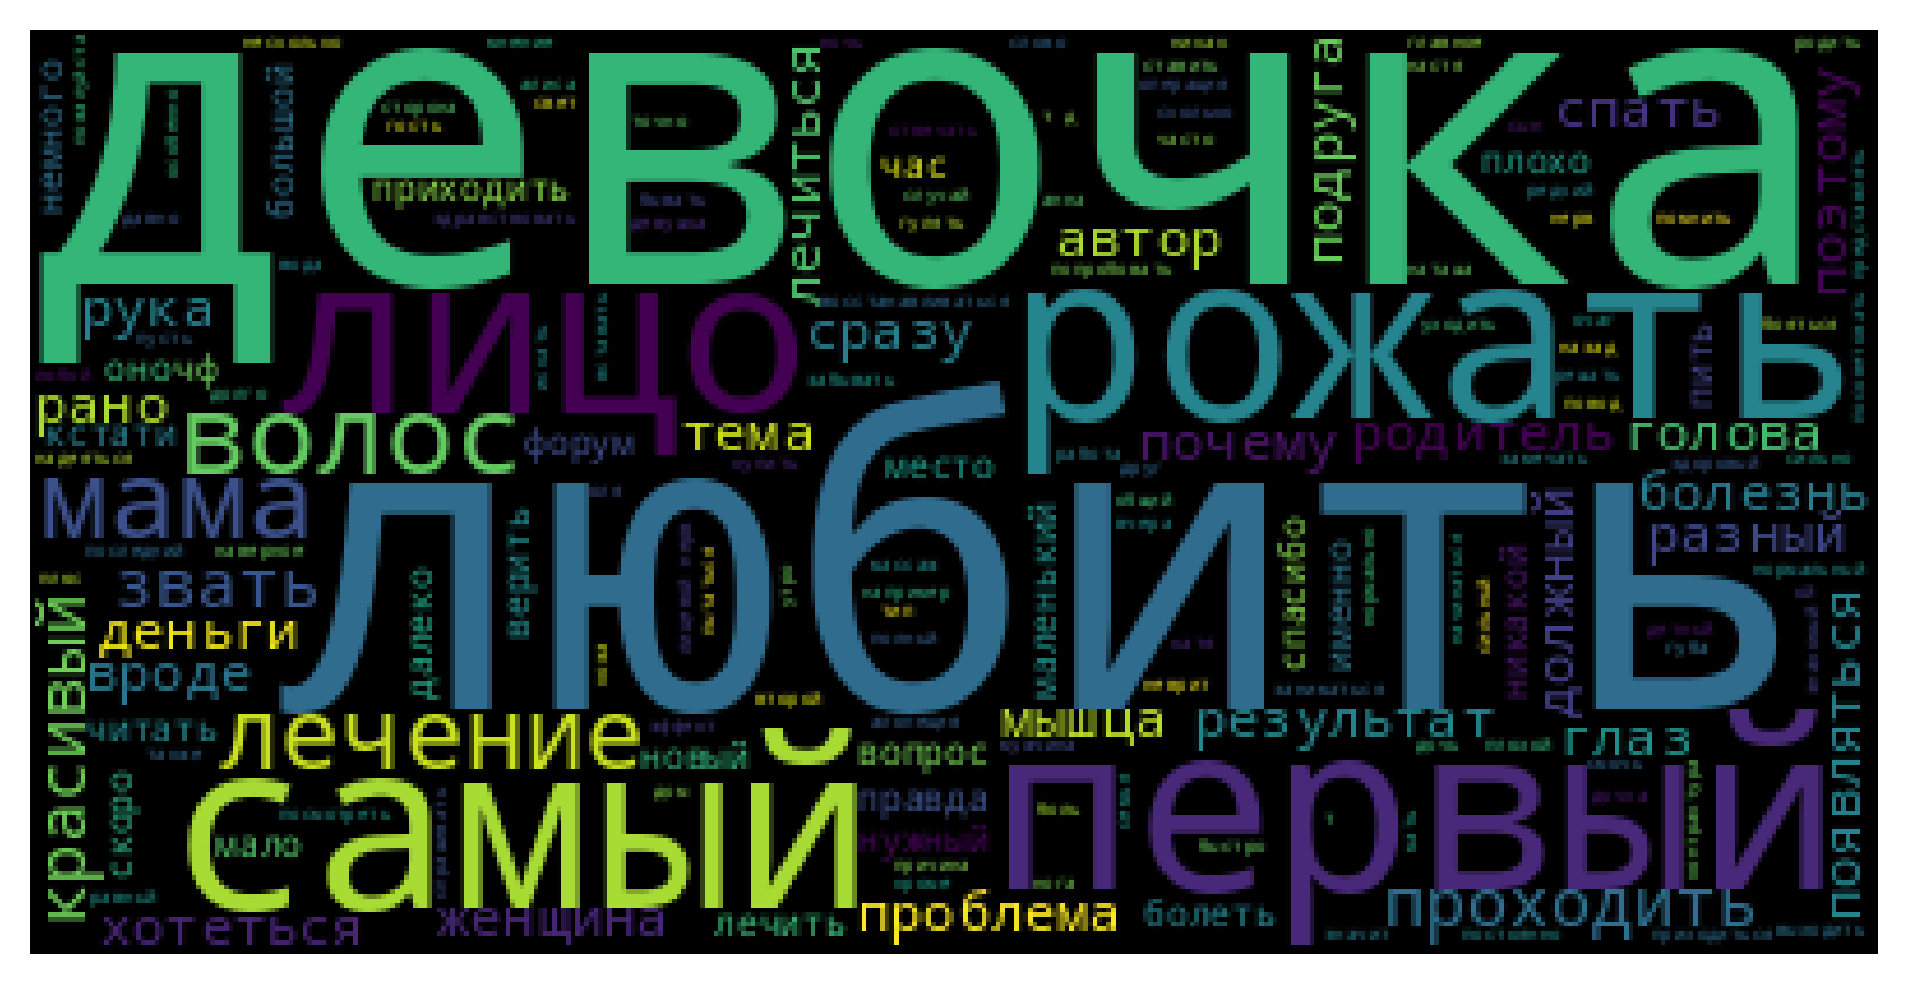

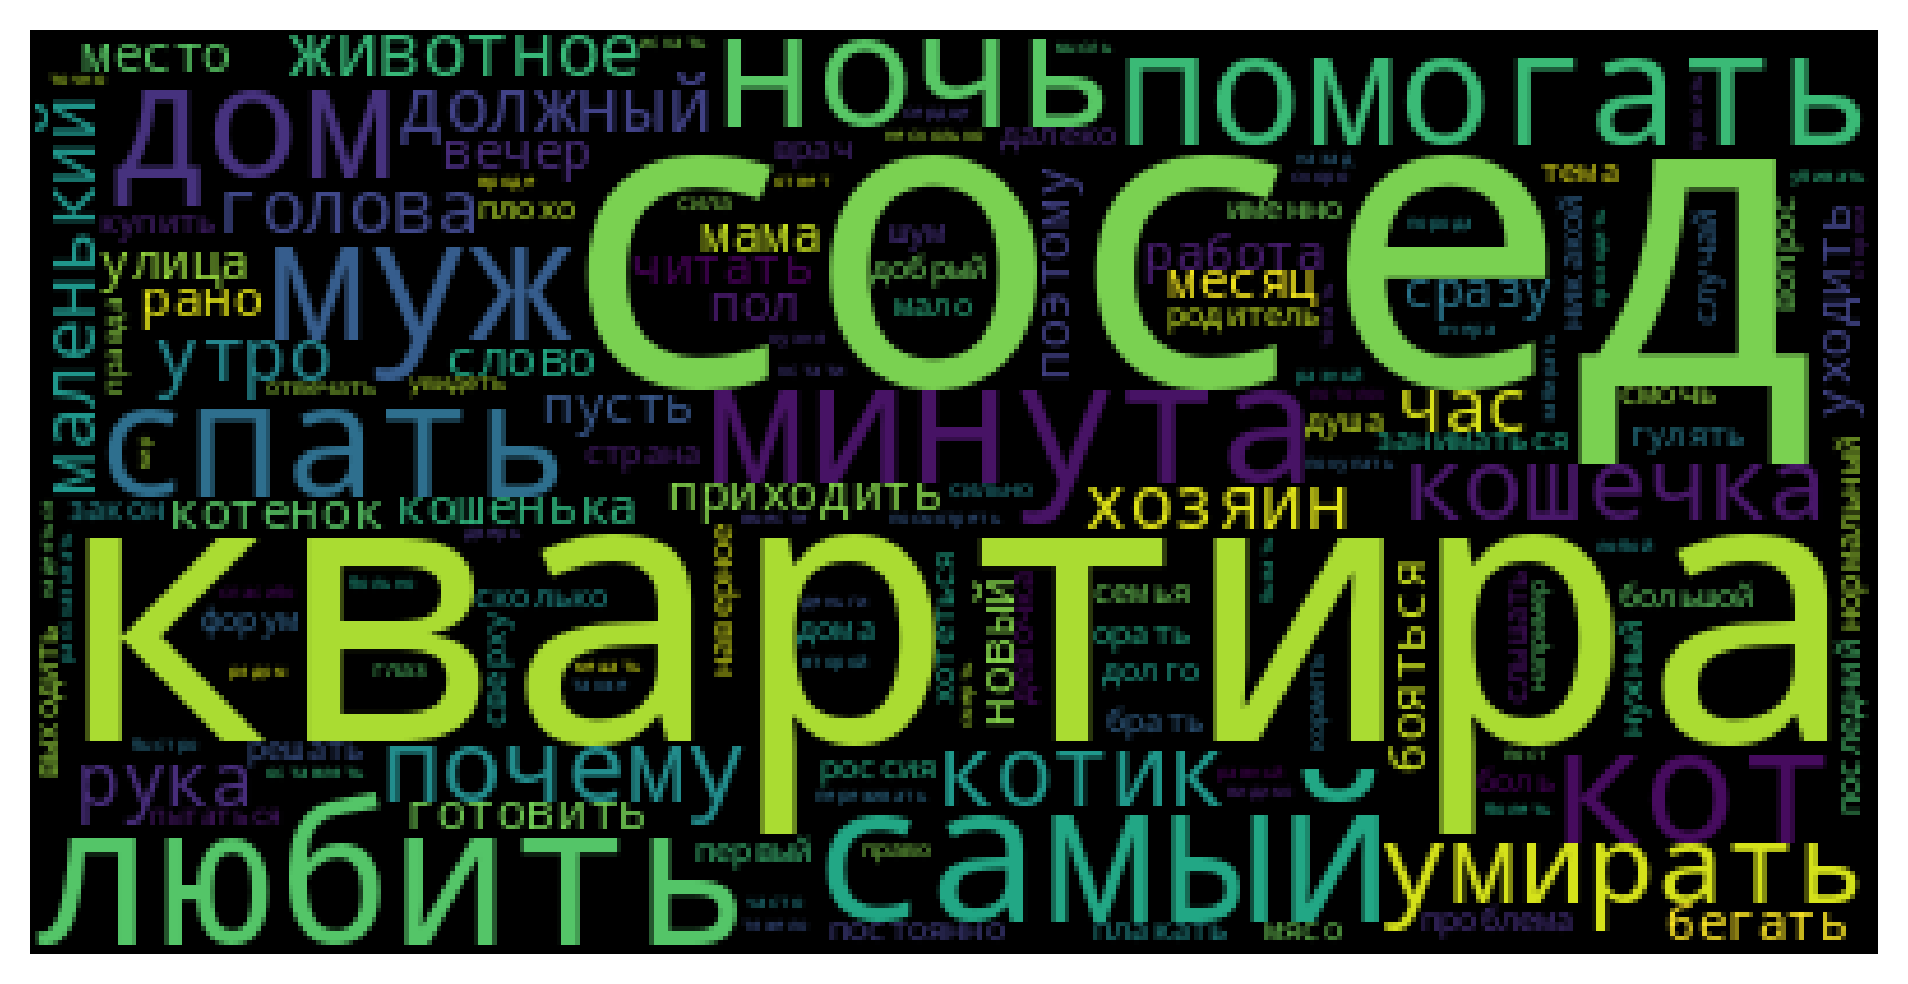

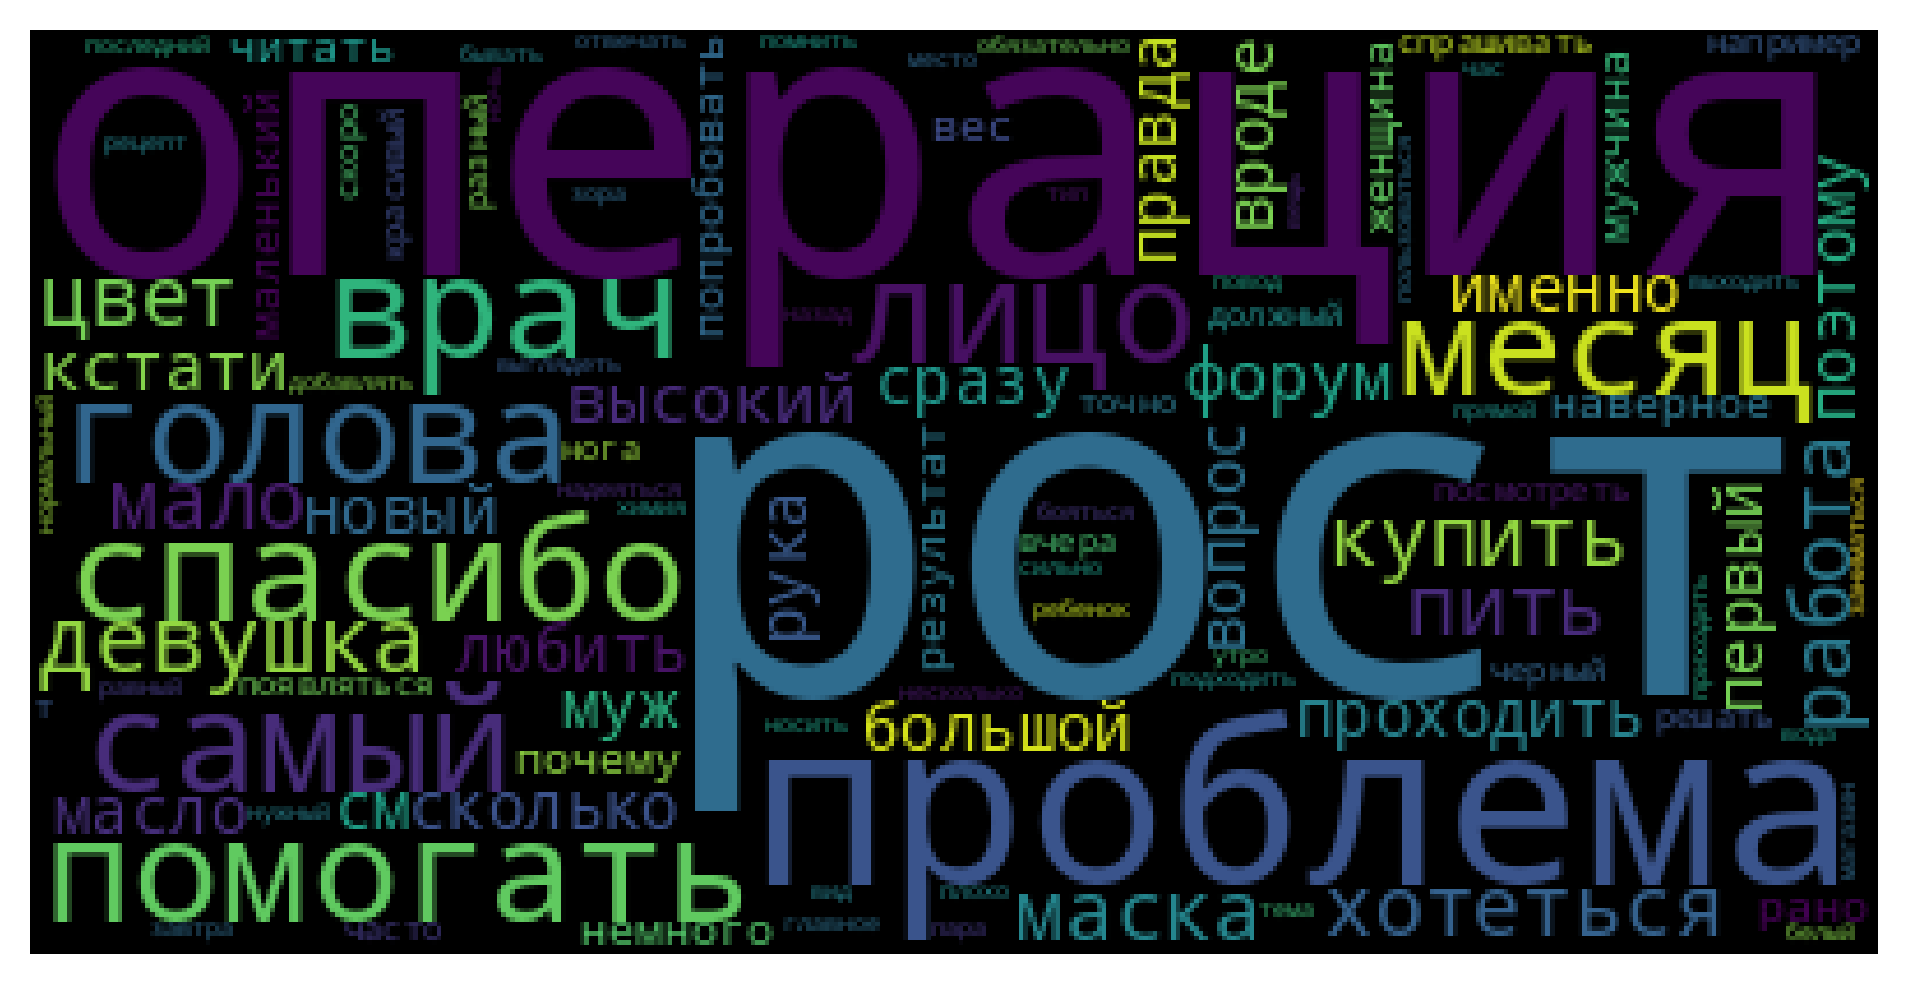

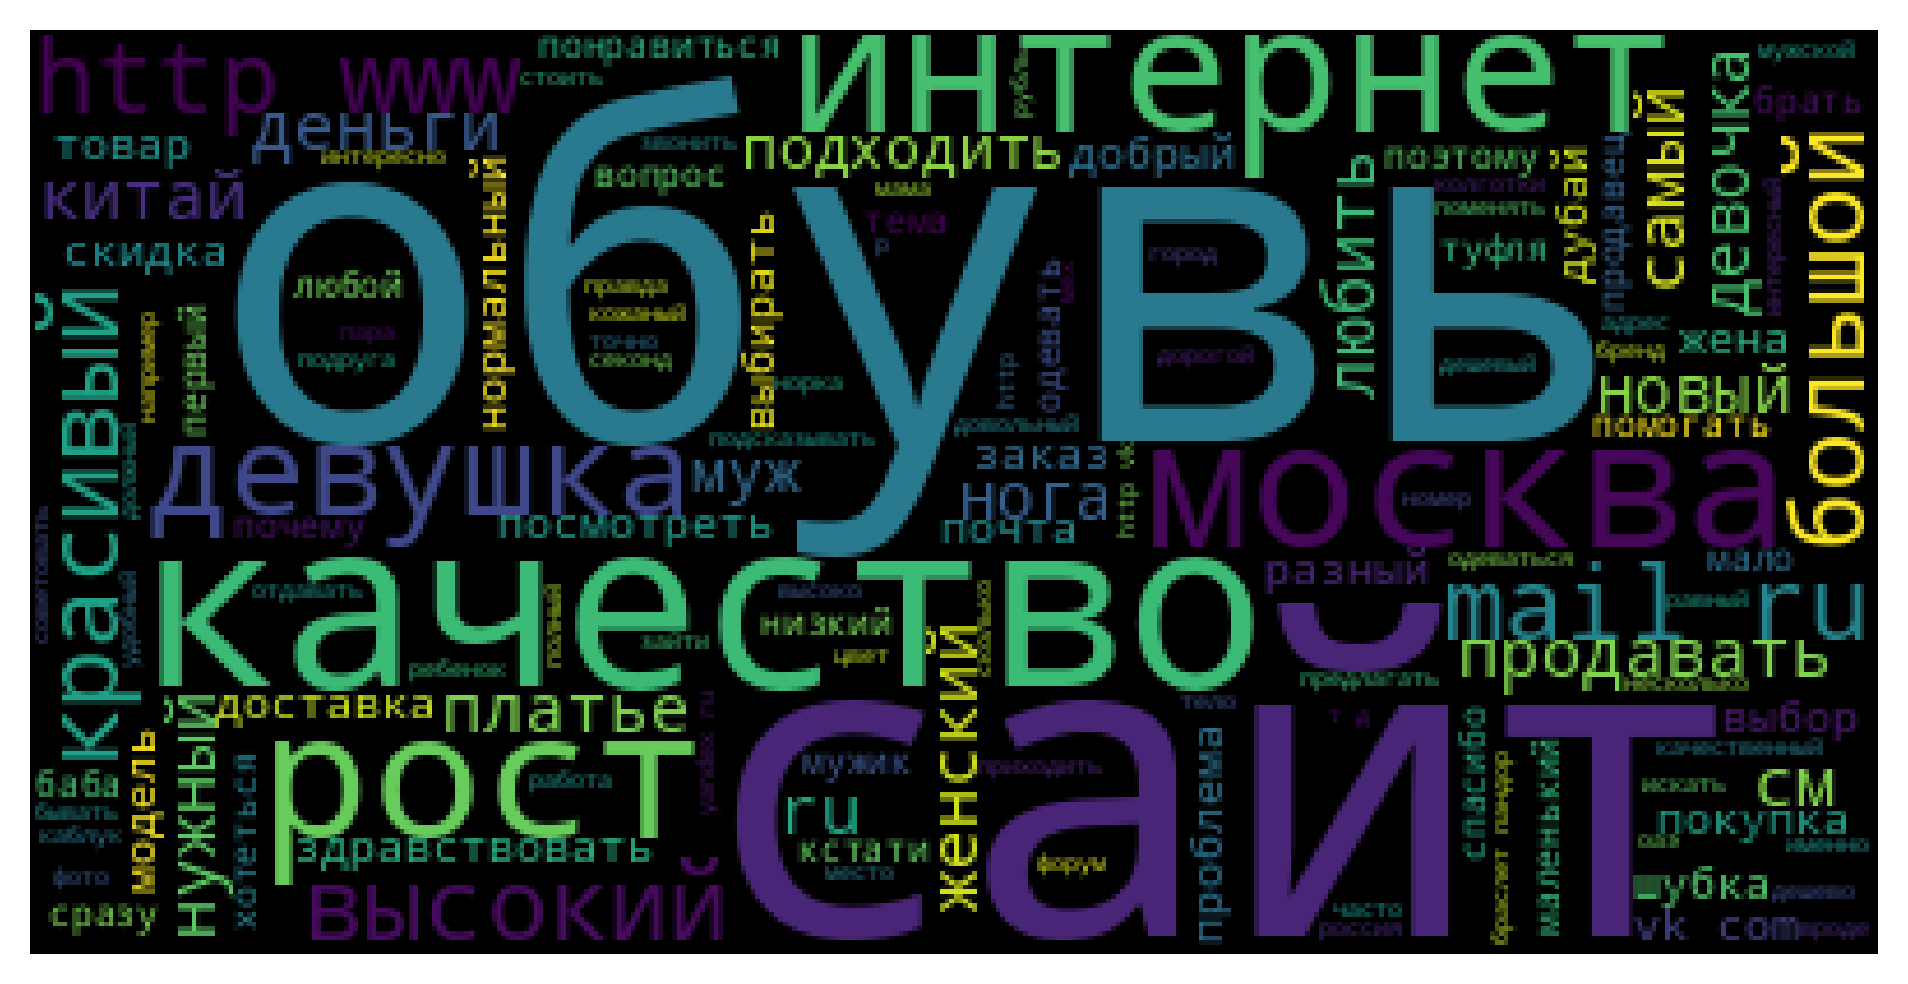

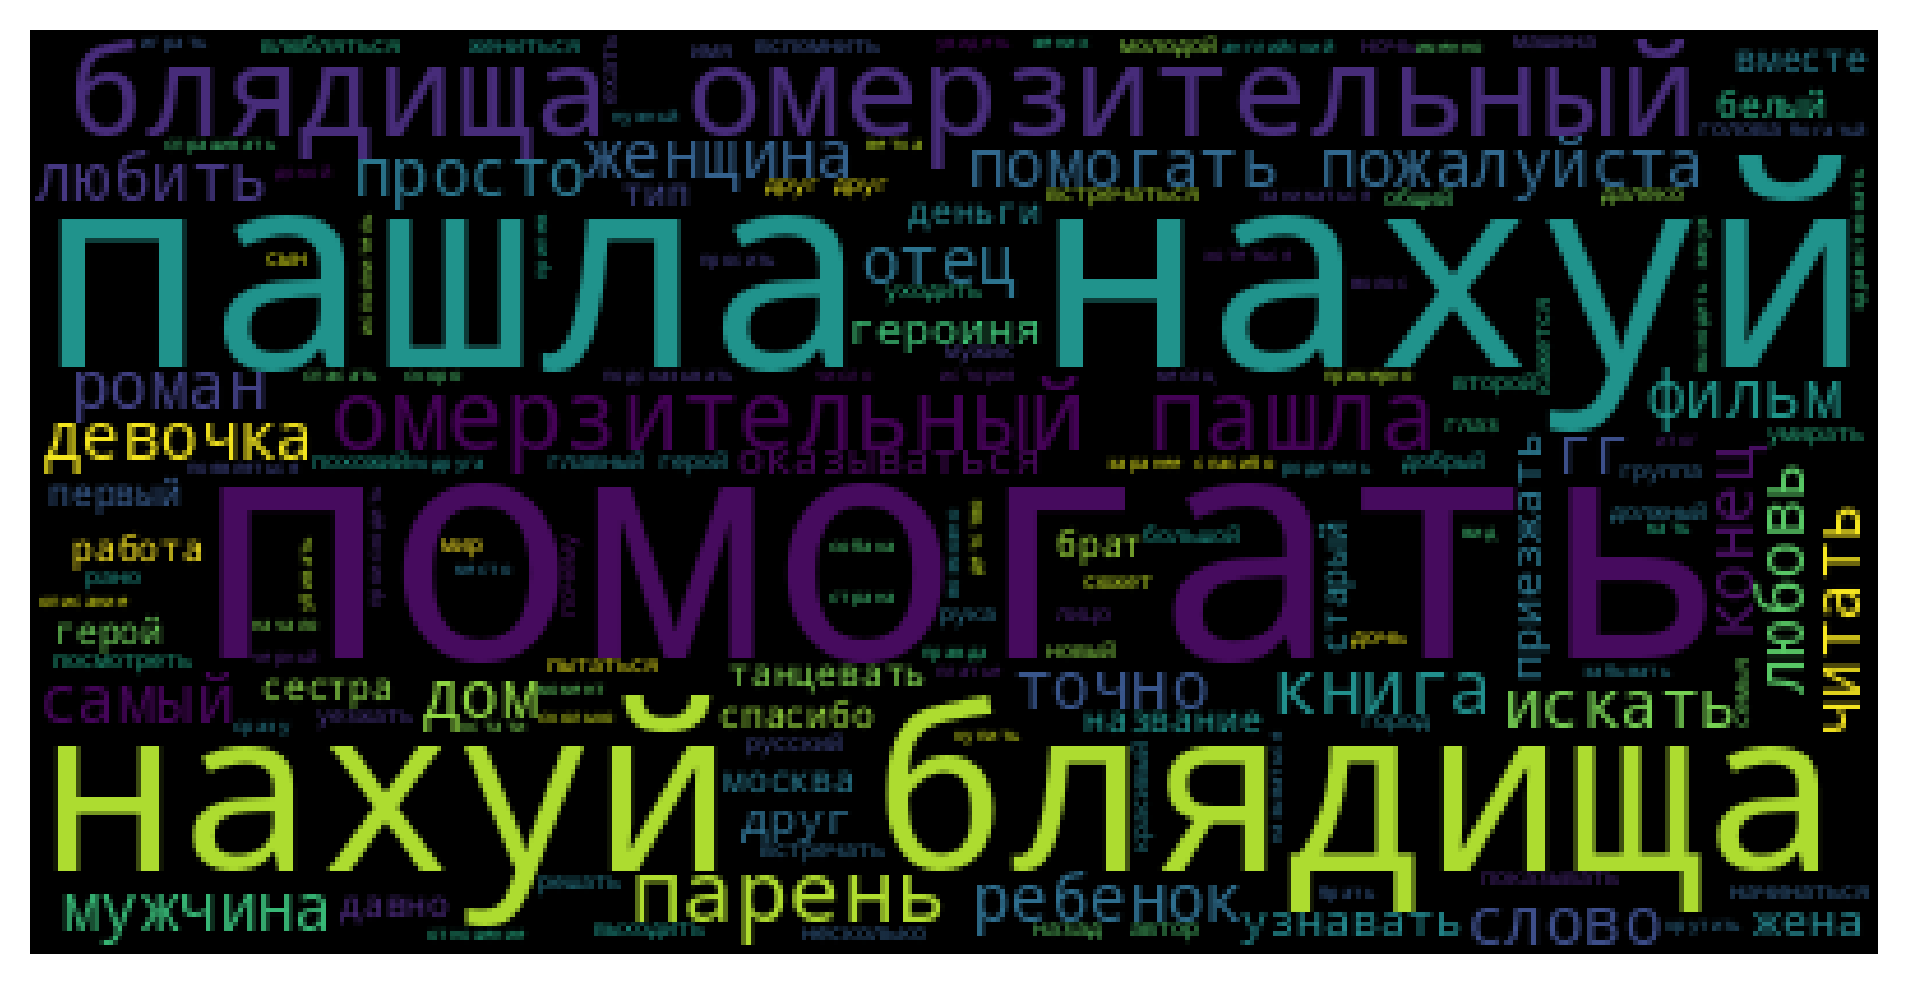

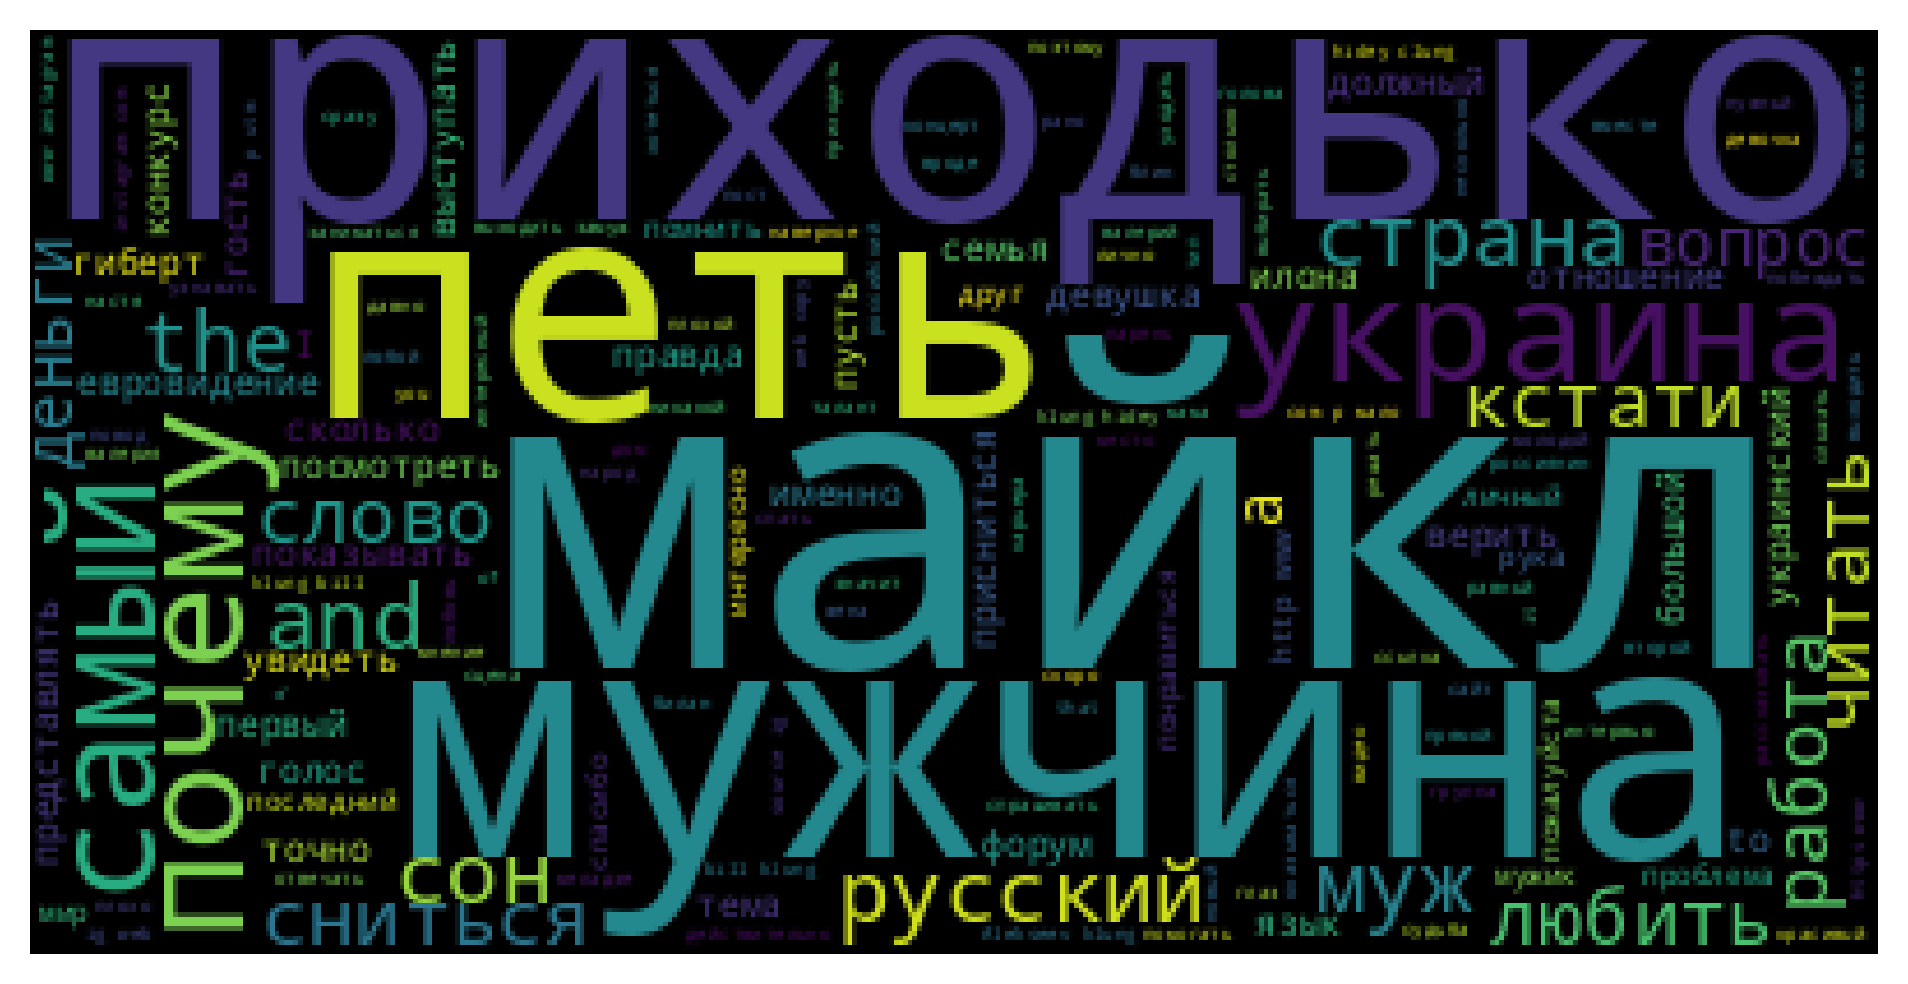

In [ ]:

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topics = ['relations', 'psycho', 'health', 'kids', 'home', 'beauty', 'fashion', 'rest', 'stars']
for top in topics:
  df = res.groupby('topic')['text'].apply(lambda x: ' '.join(x))
  relations = df.loc[top]
  relations_l = preprocessing_cloud_topic(relations)
  stopwords_p = stopwords.words('russian')
  relations_cloud = WordCloud(stopwords=stopwords_p).generate(relations_l)
  relations_freq = Counter(relations_cloud.words_).most_common(500)
  common_words_p = [word for word, freq in relations_freq[:25]]
  for word in common_words_p:
    stopwords_p.append(word)
  stopwords_p.extend(['быть', "нравиться", "ничто", "никто", "наш", "сегодня", "ждать", "написать", "дело", "ходить", "казаться", "давать",
                      "мочь", "сказать", "говорить", "хотеть", "иметь", "видеть", "думать", "сделать", "понимать", "жить", "делать", "работать", "стоять", "считать", "смотреть", "взять", "получать",
 "сидеть", "становиться", "спросить", "время", "ваш", "хороший", "жизнь", "день", "твой", "писать", "получаться", "находить", "хотя", "вообще", "неделя", "нужно", "являться", "привет", "принимать", "пока", "становиться", "начинать", "каждый", "называть", "идти", "пойти", "оставаться"])
  toxic_cloud = WordCloud(stopwords=stopwords_p).generate(relations_l)
  plt.figure(figsize=(8, 4), dpi=300)
  plt.imshow(toxic_cloud)
  plt.axis("off")
  plt.savefig(f'{top}.png')
  plt.show()